In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import math
import datetime
from datetime import timedelta,date
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError, Huber,MeanAbsoluteError
from keras.layers import Dense, LSTM, Reshape,Dropout,Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from vmdpy import VMD

In [2]:
df_wind= pd.read_csv("database//nasa_windspeed_dataset_2019_2022.csv", header = 13)

NASA/POWER CERES/MERRA2 Native Resolution Hourly Data 
- Dates (month/day/year): 01/01/2019 through 12/31/2022 
- Location: Latitude  -6.9726   Longitude -40.3438 
- Elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 551.85 meters
The value for missing source data that cannot be computed or is outside of the sources availability range: -999 

Parameter(s): 
- WS50M           MERRA-2 Wind Speed at 50 Meters (m/s) 
- WD50M           MERRA-2 Wind Direction at 50 Meters (Degrees) 
- PRECTOTCORR     MERRA-2 Precipitation Corrected (mm/hour) 
- T2M             MERRA-2 Temperature at 2 Meters (C) 
- QV2M            MERRA-2 Specific Humidity at 2 Meters (g/kg) 

In [3]:
#Creating a copy of the dataframe to manipulate
df_wind.columns = df_wind.columns.str.lower()
df_wind.columns

Index(['year', 'mo', 'dy', 'hr', 'ws50m', 'wd50m', 'prectotcorr', 't2m',
       'qv2m'],
      dtype='object')

Importing the dataset

In [4]:
#renaming column names
df_wind.rename(columns = {'mo': 'month' , 
                          'dy':'day', 
                          'hr':'hour',
                          'ws50m':'ws50',
                          'wd50m': 'wd50',
                          'prectotcorr': 'precipitation',
                          't2m':'ground_temp',
                          'qv2m':'humidity'}, inplace = True)

#adjusting the datetime values into one column and removing the non necessary ones
df_wind['datetime'] = pd.to_datetime(df_wind[['year','month','day','hour']])
df_wind.drop(columns = ['year','month','day','hour'], inplace = True)

Selecting the features:

In [5]:
df_wind = df_wind[df_wind['datetime'] >= '2020-01-01']
df_wind.head()

,ws50,wd50,precipitation,ground_temp,humidity,datetime
8763,5.69,21.85,0.15,21.89,15.32,2020-01-01 00:00:00
8764,5.52,25.84,0.13,21.56,15.20,2020-01-01 01:00:00
8765,5.16,31.50,0.15,21.27,15.20,2020-01-01 02:00:00
8766,4.79,36.91,0.25,21.03,15.26,2020-01-01 03:00:00
8767,4.54,40.60,0.50,20.95,15.38,2020-01-01 04:00:00


In [6]:
#Ciclical encoding datetime object:
day = 1
year = day*365

#hourly data, each day has 24 timesteps 
steps_per_day = 24

#Convert into an number
timestamp_s = pd.to_datetime(df_wind['datetime']).map(datetime.datetime.timestamp)

#Ciclical enconding for sin and cos
df_wind = df_wind.assign(year_sin = (np.sin(timestamp_s * (2*np.pi/year))).values)
df_wind = df_wind.assign(year_cos = (np.cos(timestamp_s * (2*np.pi/year))).values)
df_wind = df_wind.assign(day_sin = (np.sin(timestamp_s * (2*np.pi/day))).values)
df_wind = df_wind.assign(day_cos = (np.cos(timestamp_s * (2*np.pi/day))).values)

#Save the dates into another variable and remove it from the original dataframe
saved_dates = df_wind['datetime']
saved_dates = saved_dates.reset_index(drop=True)

df_wind.drop('datetime', axis = 1, inplace = True)

In [7]:
df_wind.head()

,ws50,wd50,precipitation,ground_temp,humidity,year_sin,year_cos,day_sin,day_cos
8763,5.69,21.85,0.15,21.89,15.32,7.583058e-01,0.651899,-9.802077e-07,1.0
8764,5.52,25.84,0.13,21.56,15.20,-4.337983e-09,1.000000,-9.612405e-07,1.0
8765,5.16,31.50,0.15,21.27,15.20,-7.583058e-01,0.651899,-9.422733e-07,1.0
8766,4.79,36.91,0.25,21.03,15.26,-9.886776e-01,-0.150055,-9.233061e-07,1.0
8767,4.54,40.60,0.50,20.95,15.38,-5.307300e-01,-0.847541,-9.043389e-07,1.0


In [8]:
def vmd(windspeed):
    
    alpha = 2000     # moderate bandwidth constraint  
    tau = 0           # noise-tolerance (no strict fidelity enforcement)  
    k_nmodes = 40             # n modes  
    DC = 0             # no DC part imposed  
    init = 0           # initialize omegas uniformly  
    tol = 1e-6
    u, u_hat, omega = VMD(windspeed,alpha,tau,k_nmodes,DC,init,tol)

    return(u)

In [9]:
#Applying Variational Mode Decomposition into the wind speed values:
#The objective is to decompose de original wind speed into K series
#In which the sum of those K series are equal to the original wind speed value for each time step

windspeed = df_wind['ws50'].values
u = vmd(windspeed)

In [10]:
#The decomposed return a pair number of values, removing the last row of the dataframe to match the array size with
#the dataframe index
df_wind.drop(df_wind.index[-1], inplace=True)

In [11]:
#Iterate trought the decomposed wind speed array (u) and append its values to a column in the df_wind dataframe
label_columns = []

for i in range(len(u)):
    col_name = 'ws_dec_' + str(i+1)
    df_wind[col_name] = u[i]  
    label_columns.append('ws_dec_'+str(i+1))

#real_windspeed = df_wind['wind'].values

df_wind = df_wind.drop(['ws50'],axis = 1)

In [12]:
n = len(df_wind)

# Split 70:20:10 (train:validation:test)
train_df = df_wind[0:int(n*0.7)]
val_df = df_wind[int(n*0.7):int(n*0.9)]
test_df = df_wind[int(n*0.9):]

#define batch training size
batch_size = 32

#retrieve the max and min values of each feature. This will be used to bring those values back to the original
#dimesion after scalling it to train the model
min_values = train_df.min()
max_values = train_df.max()

In [13]:
#Scaling the dataframes to train
scaler = MinMaxScaler()
scaler.fit(train_df)

scal_df = df_wind.copy()
scal_df[scal_df.columns] = scaler.transform(df_wind[df_wind.columns])

scal_train_df = train_df.copy()
scal_train_df[scal_train_df.columns] = scaler.transform(train_df[train_df.columns])

scal_val_df = val_df.copy()
scal_val_df[scal_val_df.columns] = scaler.transform(val_df[val_df.columns])

scal_test_df = test_df.copy()
scal_test_df[scal_test_df.columns] = scaler.transform(test_df[test_df.columns])

In [22]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=scal_train_df, val_df=scal_val_df, test_df=scal_test_df, 
                 label_columns=None, min_values=min_values,max_values=max_values,batch_size=batch_size,plot_col=label_columns,
                 steps_per_day=steps_per_day):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.train_min = train_df.min()
        self.train_max = train_df.max()

        self.steps_per_day = steps_per_day

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col=label_columns, max_subplots=3):
        inputs, labels = self.sample_batch

        fig = plt.figure(figsize=(18, 8))
        plot_col_index = [self.column_indices[col] for col in plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel('Windspeed (m/s)')
            plt.ylim(0,20)
            
            sliced_inputs = inputs[:,:,-len(plot_col):]
            original_scale_inputs = scale_back(sliced_inputs,min_values,max_values,plot_col)
            summed_inputs = tf.math.reduce_sum(original_scale_inputs,axis=2,keepdims=False,name=None)
            
            plt.plot(self.input_indices, 
                     summed_inputs[n],
                     
                     label='Inputs', 
                     marker='.',
                     c='#2E294E',
                     zorder=-10)

            if self.label_columns:
                label_col_index = [self.label_columns_indices.get(col, None) for col in plot_col]
            else:
                label_col_index = plot_col_index

            if None in label_col_index:
                continue
            
            original_scale_labels = scale_back(labels,min_values,max_values,plot_col)
            summed_label = tf.math.reduce_sum(original_scale_labels,axis=2,keepdims=False,name=None)
            #label_avg = calc_ws_avg(summed_label[n],steps_per_day)
            
            forecasting_period = int((len(summed_label[n]))/steps_per_day)

            plt.plot(self.label_indices, 
                        summed_label[n],
                        label='Labels',
                        marker='.',
                        c='#541388'
                        )
           
            if model is not None:

                predictions = model(inputs)
                original_scale_predictions = scale_back(predictions,min_values,max_values,plot_col)
                summed_predictions = tf.math.reduce_sum(original_scale_predictions,axis=2,keepdims=False,name=None)
                #predictions_avg = calc_ws_avg(summed_predictions[n],steps_per_day)

                plt.plot(self.label_indices, 
                            summed_predictions[n], 
                            label='Predictions',
                            marker='.',
                            c='#D90368'
                            )
                
                plt.text(x=5,y=17,s='avg_ws')

                x_0 = int(len(summed_inputs[n]))
                text_position = x_0 

                plt.rcParams.update({'font.size': 7})

                # for day in range(forecasting_period):
                    
                #     text_string = 'day_' + str(day+1) + ': r = ' + str(label_avg[day]) + '| p = '+ str(predictions_avg[day])
                    
                #     plt.text(x=text_position + 3, y=17, s=text_string)
                #     plt.axvline(x=text_position, color='black',ymin = 0, ymax = (18/20),ls=':')
                #     text_position = text_position + steps_per_day

                    
            if n == 0:
                fig.legend()

        plt.xlabel('Time [daily]')
        return(fig)
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.test))
            self._sample_batch = result
        return result

In [15]:
def compile_and_fit(model, window, patience=5, max_epochs=100):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='auto')
    
    model.compile(loss=MeanAbsoluteError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [23]:
input_days = 3
forecast_days = 7
features = len(df_wind.columns)

label_columns = label_columns
input_width = steps_per_day*input_days
label_width = steps_per_day*forecast_days
shift = steps_per_day*forecast_days

mo_val_performance = {}
mo_performance = {}

multi_step_window = DataWindow(input_width = input_width, 
                            label_width=label_width, 
                            shift=shift, 
                            label_columns=label_columns,
                            batch_size=batch_size,
                            steps_per_day=steps_per_day)

In [17]:
def scale_back(scaled_values,val_min,val_max,label_columns,variable = 'windspeed'):

        if variable == 'windspeed':       
                min_values = val_min.tail(len(label_columns)).values
                max_values = val_max.tail(len(label_columns)).values
                
        elif variable == 'val_loss':
                min_values = val_min.head(1).values
                max_values = val_max.head(1).values

        scaled_back = scaled_values * (max_values - min_values) + min_values

        return scaled_back

In [18]:
def plot_loss(history):

    fig,ax= plt.subplots()

    ax.plot(range(len(hist.history['loss'])),hist.history['loss'],label='loss',color='#D90368')
    ax.plot(range(len(hist.history['val_loss'])),hist.history['val_loss'],label='val_loss',color='#2E294E')

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_title('training loss')
    leg = ax.legend()

    return(fig)

In [19]:
val_performance = {}
test_performance = {}

#Layers Units (LU)
first_lu = 16
seccond_lu = 32
third_lu = 64
forth_lu = 0

#Dropouts (DO)
first_do = 0.0
seccond_do = 0.0

teorical_lstm = Sequential([
    Bidirectional(LSTM(units = first_lu,input_shape=(input_width,features),return_sequences=True)),
    Dropout(first_do),
    Bidirectional(LSTM(units = seccond_lu,return_sequences=True)),
    Dropout(seccond_do),
    Bidirectional(LSTM(units = third_lu)),
    Dense(units=shift*len(label_columns)),
    Reshape((shift,len(label_columns)))
])

hist = compile_and_fit(teorical_lstm,multi_step_window)

val_performance['LSTM'] = teorical_lstm.evaluate(multi_step_window.val)
test_performance['LSTM'] = teorical_lstm.evaluate(multi_step_window.test,verbose = 0)

Epoch 1/100
568/568 [==============================] - 93s 134ms/step - loss: 0.1157 - mean_absolute_error: 0.1157 - val_loss: 0.1012 - val_mean_absolute_error: 0.1012
Epoch 2/100
568/568 [==============================] - 70s 124ms/step - loss: 0.1063 - mean_absolute_error: 0.1063 - val_loss: 0.0964 - val_mean_absolute_error: 0.0964
Epoch 3/100
568/568 [==============================] - 71s 125ms/step - loss: 0.0968 - mean_absolute_error: 0.0968 - val_loss: 0.0883 - val_mean_absolute_error: 0.0883
Epoch 4/100
568/568 [==============================] - 71s 126ms/step - loss: 0.0911 - mean_absolute_error: 0.0911 - val_loss: 0.0834 - val_mean_absolute_error: 0.0834
Epoch 5/100
568/568 [==============================] - 71s 125ms/step - loss: 0.0862 - mean_absolute_error: 0.0862 - val_loss: 0.0803 - val_mean_absolute_error: 0.0803
Epoch 6/100
568/568 [==============================] - 72s 127ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0770 - val_mean_absolute_error:

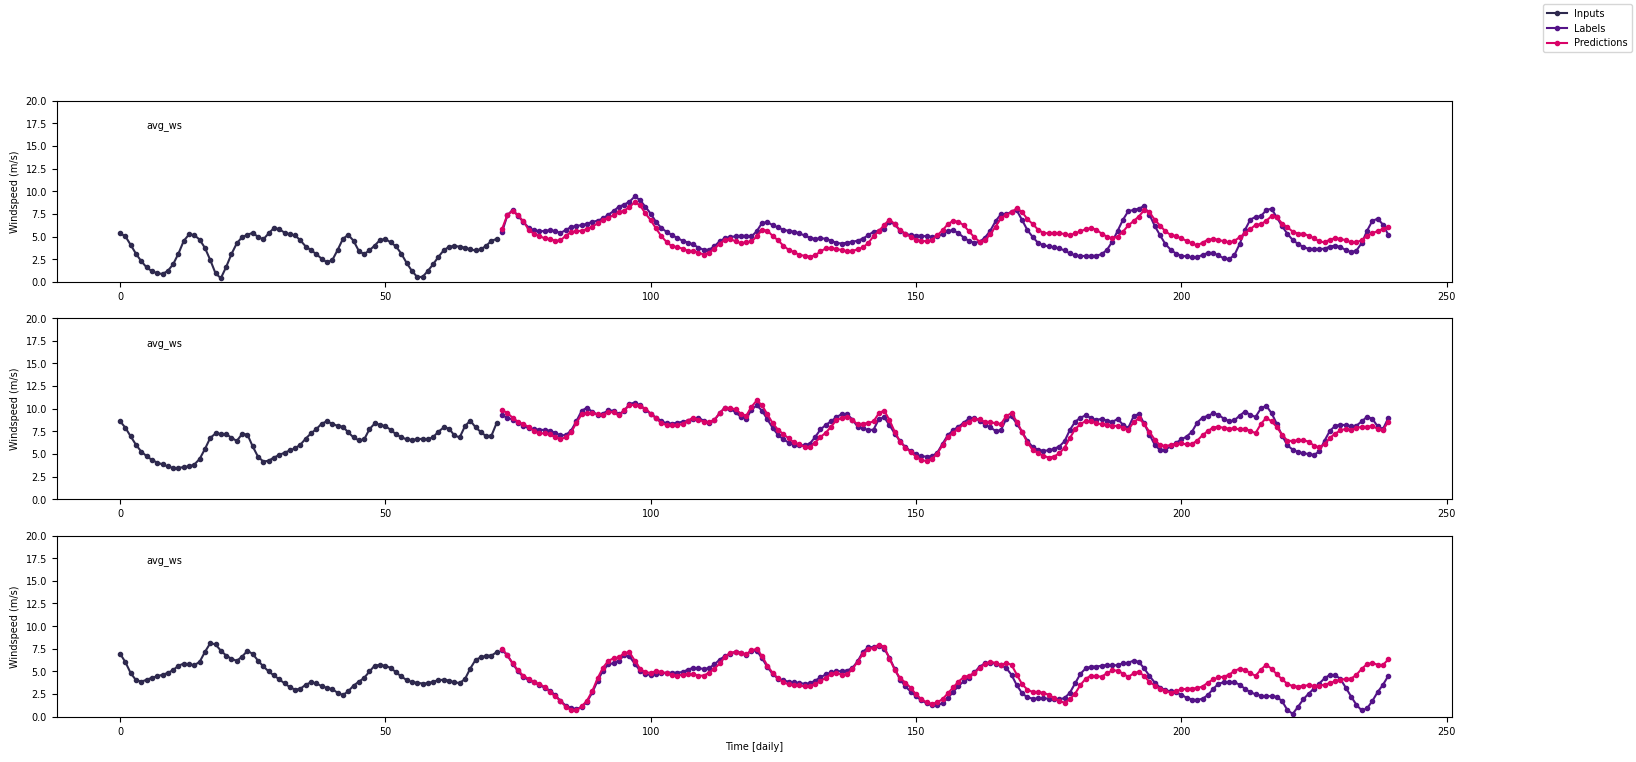

In [24]:
forecast = multi_step_window.plot(model = teorical_lstm)

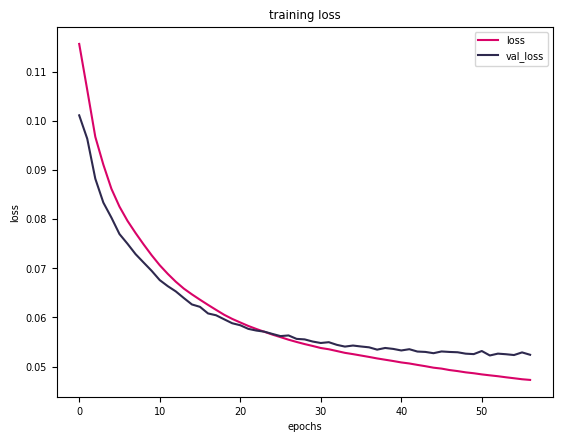

In [21]:
loss_fig = plot_loss(hist)